In [5]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from labeling import *
from CO2_identify import resize3d, mute_top
from itertools import product
from collections import OrderedDict
from scipy.ndimage import gaussian_filter
from sklearn.neighbors import NearestNeighbors

import pandas as pd
import json
import torch

In [6]:
fn = '../define_path.txt'             #add your path
with open(fn) as f:
    lines = f.readlines()
for idx, line in enumerate(lines):
    if idx == 1:
        dir_co2 = line.split('=')[1][:-1]
    if idx == 3:
        dir_grid = line.split('=')[1][:-1]
    if idx == 5:
        outpath = line.split('=')[1][:-1]

# Training dataset

##  Basic pathes for baseline data and time-lapse data    #add your data paths

In [8]:
# file pathes
blfn = f'{dir_co2}/94p10/data/94p10nea.sgy' # baseline data processed in 2010       #add your path
blfn2 = f'{dir_co2}/94p01/data/94p01nea.sgy' # baseline data processed in 2001       #add your path
tlfn = f'{dir_co2}/10p10/data/10p10nea.sgy' # timelapse (2010) data processed in 2010    #add your path
tlfn2 = f'{dir_co2}/10p11/data/10p11nea.sgy' # timelapse (2011) data processed in 2011     #add your path
mkfn = f'/scratch/gilbreth/pate2126/DKP_new/resources/label/masks.dat' # CO2 masks interpreted from 1994 and 2010 data processed in 2010




## Load data

In [9]:
# load the data head
D0 = dataload(fn=blfn)
D0n = dataload(fn=blfn2)
Dt = dataload(fn=tlfn)
Dtn = dataload(fn=tlfn2)

Total trace number: 150909
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 269 (number of ensembles) x 561 (trace number per ensemble) x 1001 (sample number per trace)
Total trace number: 166747
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 287 (number of ensembles) x 581 (trace number per ensemble) x 1001 (sample number per trace)
Total trace number: 150909
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 269 (number of ensembles) x 561 (trace number per ensemble) x 1001 (sample number per trace)
Total trace number: 242136
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 216 (number of ensembles) x 1121 (trace number per ensemble) x 1001 (sample number per trace)


In [10]:
# mask dimension
DD = (Dt.nx,Dt.ny,Dt.nt)

In [11]:
# get the entire 3D data from the three data volume
d0,xd0,yd0,td0 = D0.getdata()
d0n,xdn,ydn,_ = D0n.getdata()
dt,xd,yd,td = Dt.getdata()
dtn,xdt,ydt,tdt = Dtn.getdata()

## Preprocess d0n and dtn to make them in the same dimension as d0 and dt

In [12]:
# remove the water bottom reflection
r'''
t1,t2 = 10,20
d0 = mute_top(d0,t1,t2)
d0n = mute_top(d0n,t1,t2)
dt = mute_top(dt,t1,t2)
dtn = mute_top(dtn,t1,t2)
'''

'\nt1,t2 = 10,20\nd0 = mute_top(d0,t1,t2)\nd0n = mute_top(d0n,t1,t2)\ndt = mute_top(dt,t1,t2)\ndtn = mute_top(dtn,t1,t2)\n'

In [13]:
# observe the relative trace location between the baseline or time-lapse data and the reference data position
r'''
xm = np.amin(xd)
ym = np.amin(yd)
fig,ax = plt.subplots(1,1,figsize=(5,10))
ax.scatter(xd-xm,yd-ym,c='r')
ax.scatter(xd0-xm,yd0-ym,c='b')
ax.axis('equal')
ax.set_ylim(2000,2200)
ax.set_xlim(1200,1400)
'''

"\nxm = np.amin(xd)\nym = np.amin(yd)\nfig,ax = plt.subplots(1,1,figsize=(5,10))\nax.scatter(xd-xm,yd-ym,c='r')\nax.scatter(xd0-xm,yd0-ym,c='b')\nax.axis('equal')\nax.set_ylim(2000,2200)\nax.set_xlim(1200,1400)\n"

In [14]:
# interpolate d0n to the same dimension as dt(d0)
X = np.stack((xd.flatten(),yd.flatten()),axis=1)
Xn = np.stack((xdn.flatten(),ydn.flatten()),axis=1)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Xn)
distances, ind = nbrs.kneighbors(X)
sub = ind2sub(xdn.shape,ind)
d0i = d0n[sub[0],sub[1],:]
d0i = np.reshape(d0i,d0.shape)

In [15]:
# interpolate dtn the same dimension as dt(d0)
# downsample along xline direction
dtn1 = np.pad(dtn[:,1:-3:2,:],((0,0),(2,0),(0,0)),'edge')
# calculate the coefficient for linear interpolation
xdh,xdth = xd[:,0],xdt[:,0]
X = np.stack((xdh,np.zeros(Dt.nx)),axis=1)
Xt = np.stack((xdth,np.zeros(Dtn.nx)),axis=1)
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(Xt)
distances, ind = nbrs.kneighbors(X)
coe = np.flip(distances,axis=1)/np.expand_dims(np.sum(distances,axis=1),1)
# linear interpolate along inline direction
dti = np.zeros(DD,dtype=np.float32)
for i in range(Dt.nx):
    dti[i,:,:] = dtn1[ind[i,0],:,:]*coe[i,0]+dtn1[ind[i,1],:,:]*coe[i,1]

In [16]:
eps = 1e-5
# normalize d0,dt,d0i,dti
d0 = (d0-np.mean(d0))/(np.std(d0)+eps)
d0i = (d0i-np.mean(d0i))/(np.std(d0i)+eps)
dt = (dt-np.mean(dt))/(np.std(dt)+eps)
dti = (dti-np.mean(dti))/(np.std(dti)+eps)

## Display the comparison between different baseline and time-lapse dataset

### Amplitude spectra comparison between all datasets

In [17]:
# calculate the four data amplitude spectra
A0 = np.mean(np.abs(np.fft.fft(d0[:,:,:])),axis=(0,1))
A0i = np.mean(np.abs(np.fft.fft(d0i[:,:,:])),axis=(0,1))
At = np.mean(np.abs(np.fft.fft(dt[:,:,:])),axis=(0,1))
Ati = np.mean(np.abs(np.fft.fft(dti[:,:,:])),axis=(0,1))

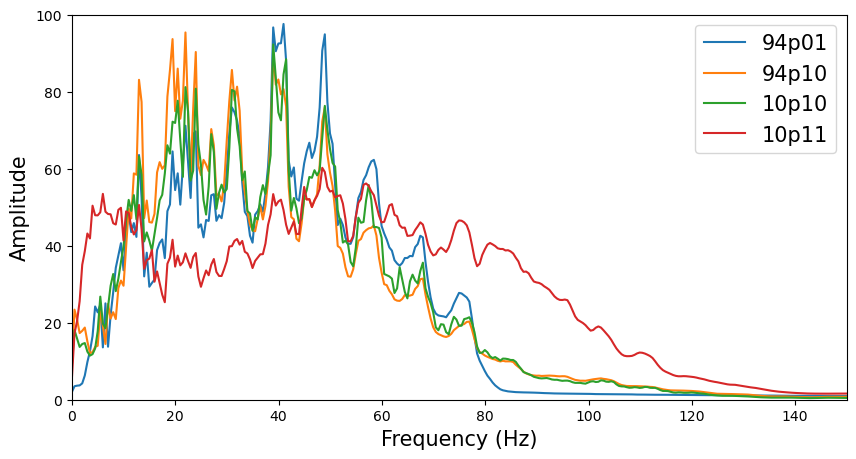

In [18]:
# amplitude comparison for the entire Inline section (Figure 4)
f = np.fft.fftfreq(len(td),td[1]-td[0])
nfp = len(td)//2
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(f[:nfp],A0i[:nfp],label=f'94p01')
ax.plot(f[:nfp],A0[:nfp],label=f'94p10')
ax.plot(f[:nfp],At[:nfp],label=f'10p10')
ax.plot(f[:nfp],Ati[:nfp],label=f'10p11')
ax.set_xlabel('Frequency (Hz)',fontsize=15)
ax.set_ylabel('Amplitude',fontsize=15)
ax.set_xlim(0,150)
ax.set_ylim(0,100)
ax.legend(fontsize=15)

### Waveform and amplitude spectra comparison between baseline data processed in different years

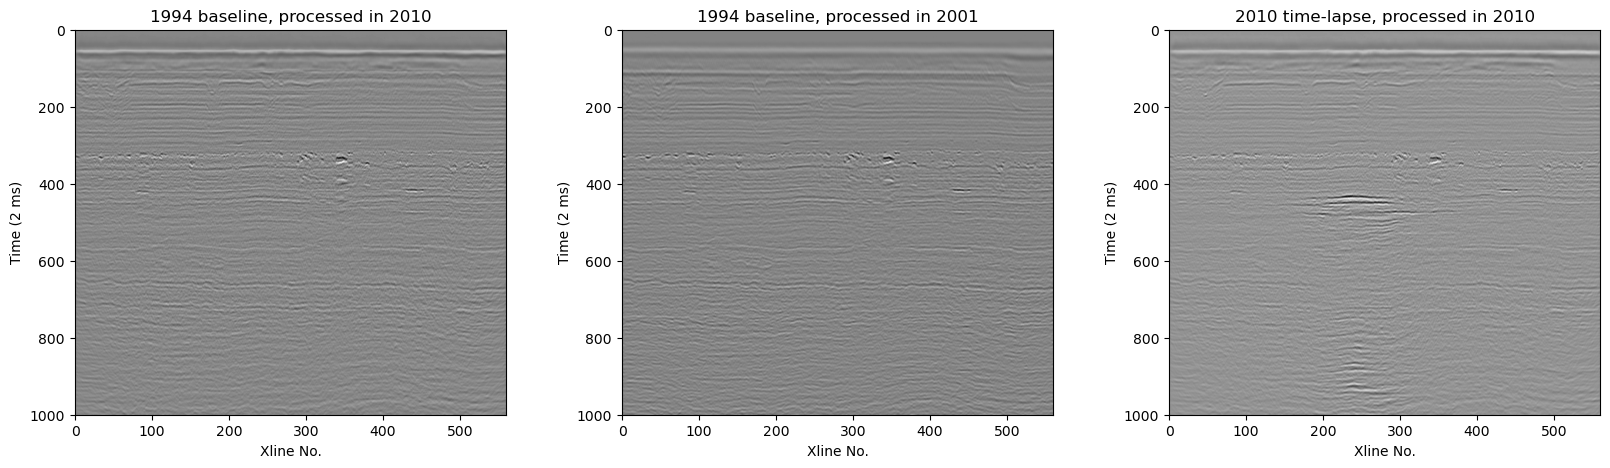

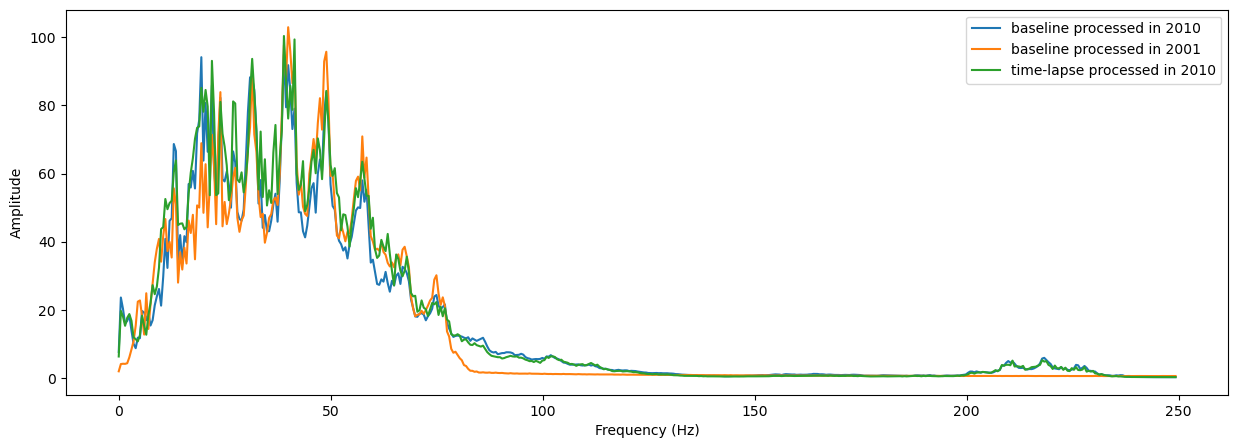

In [19]:
# inline section comparison
InN = 130
tl = ['2010','2001']
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax[0].imshow(d0[InN,:,:].T,aspect=0.5,cmap='gray')
ax[1].imshow(d0i[InN,:,:].T,aspect=0.5,cmap='gray')
ax[2].imshow(dt[InN,:,:].T,aspect=0.5,cmap='gray')
for i in range(3):
    ax[i].set_xlabel('Xline No.')
    ax[i].set_ylabel('Time (2 ms)')
    if i<2:
        ax[i].set_title(f'1994 baseline, processed in {tl[i]}')
    else:
        ax[i].set_title(f'2010 time-lapse, processed in {tl[0]}')
# amplitude comparison for the entire Inline section
f = np.fft.fftfreq(len(td),td[1]-td[0])
A0 = np.mean(np.abs(np.fft.fft(d0[InN,:,:])),axis=0)
A0i = np.mean(np.abs(np.fft.fft(d0i[InN,:,:])),axis=0)
At = np.mean(np.abs(np.fft.fft(dt[InN,:,:])),axis=0)
nfp = len(td)//2
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(f[:nfp],A0[:nfp],label=f'baseline processed in {tl[0]}')
ax.plot(f[:nfp],A0i[:nfp],label=f'baseline processed in {tl[1]}')
ax.plot(f[:nfp],At[:nfp],label=f'time-lapse processed in {tl[0]}')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.legend()

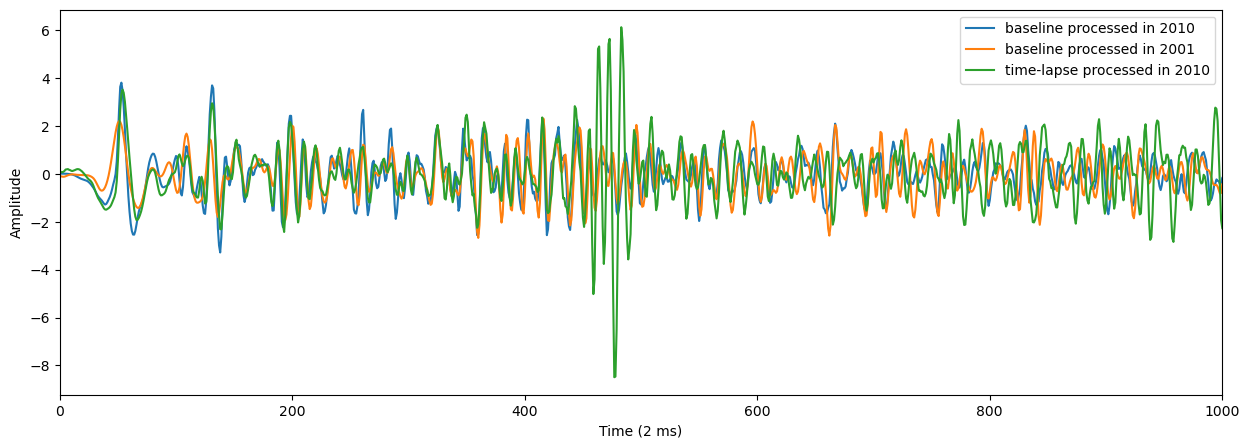

In [20]:
# trace comparison
XnN = 200
t1 = 0
t2 = 1000
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(d0[InN,XnN,:],label=f'baseline processed in {tl[0]}')
ax.plot(d0i[InN,XnN,:],label=f'baseline processed in {tl[1]}')
ax.plot(dt[InN,XnN,:],label=f'time-lapse processed in {tl[0]}')
ax.set_xlim(t1,t2)
ax.set_xlabel('Time (2 ms)')
ax.set_ylabel('Amplitude')
ax.legend()

### Waveform and amplitude spectra comparison between time-lapse data processed in different years

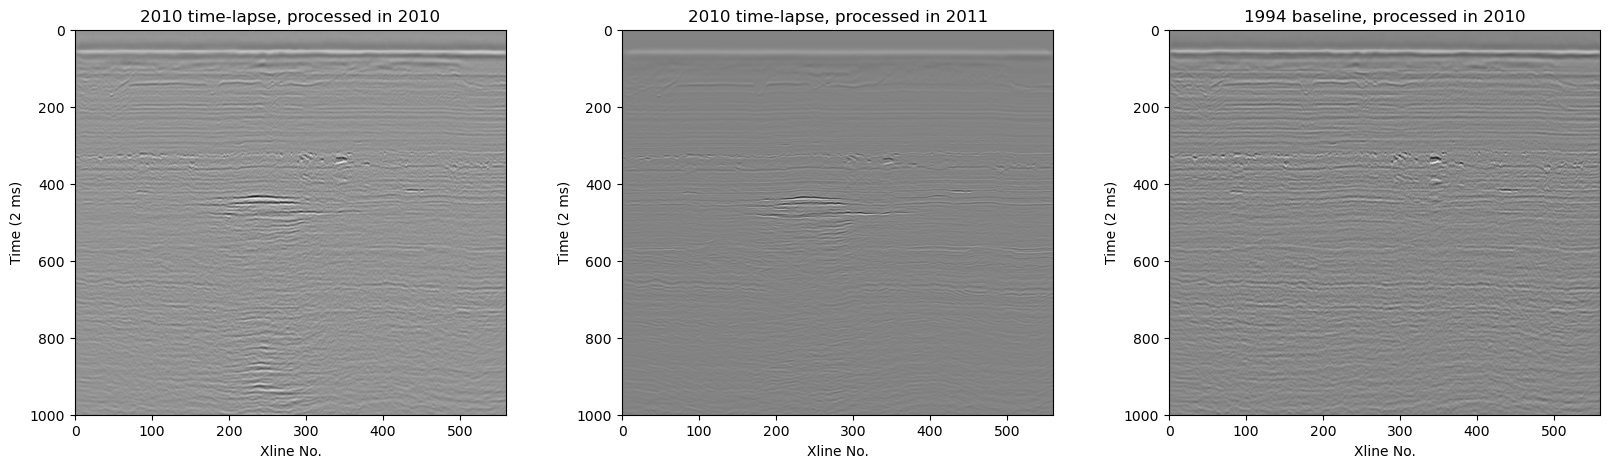

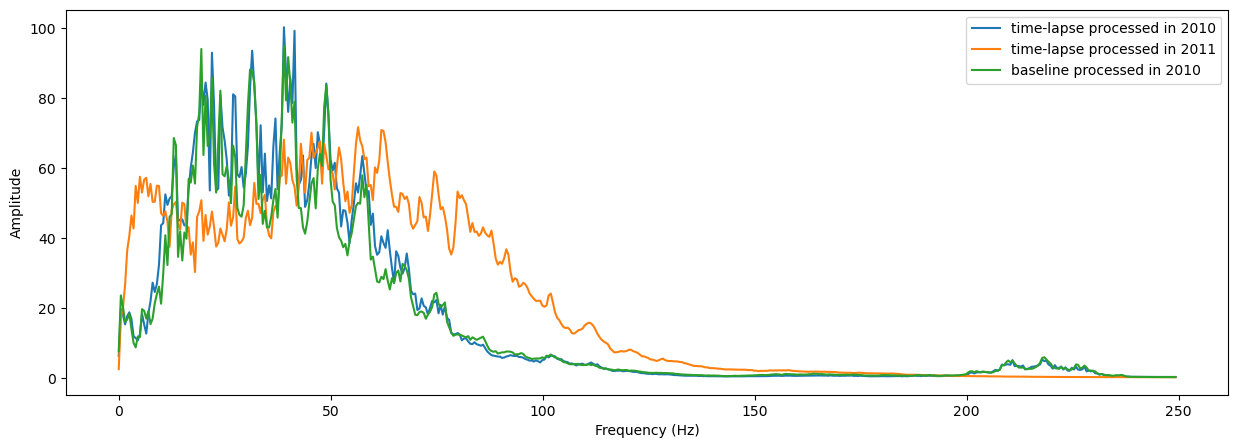

In [21]:
# inline section comparison
InN = 130
tl = ['2010','2011']
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax[0].imshow(dt[InN,:,:].T,aspect=0.5,cmap='gray')
ax[1].imshow(dti[InN,:,:].T,aspect=0.5,cmap='gray')
ax[2].imshow(d0[InN,:,:].T,aspect=0.5,cmap='gray')
for i in range(3):
    ax[i].set_xlabel('Xline No.')
    ax[i].set_ylabel('Time (2 ms)')
    if i<2:
        ax[i].set_title(f'2010 time-lapse, processed in {tl[i]}')
    else:
        ax[i].set_title(f'1994 baseline, processed in {tl[0]}')
# amplitude comparison for the entire Inline section
f = np.fft.fftfreq(len(td),td[1]-td[0])
At = np.mean(np.abs(np.fft.fft(dt[InN,:,:])),axis=0)
Ati = np.mean(np.abs(np.fft.fft(dti[InN,:,:])),axis=0)
A0 = np.mean(np.abs(np.fft.fft(d0[InN,:,:])),axis=0)
nfp = len(td)//2
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(f[:nfp],At[:nfp],label=f'time-lapse processed in {tl[0]}')
ax.plot(f[:nfp],Ati[:nfp],label=f'time-lapse processed in {tl[1]}')
ax.plot(f[:nfp],A0[:nfp],label=f'baseline processed in {tl[0]}')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.legend()

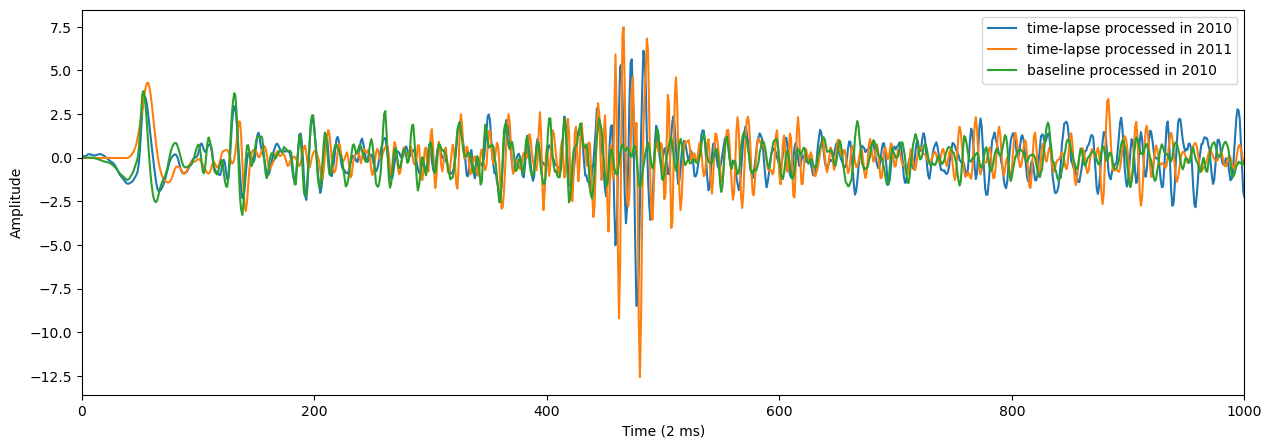

In [22]:
# trace comparison
XnN = 200
t1 = 0
t2 = 1000
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(dt[InN,XnN,:],label=f'time-lapse processed in {tl[0]}')
ax.plot(dti[InN,XnN,:],label=f'time-lapse processed in {tl[1]}')
ax.plot(d0[InN,XnN,:],label=f'baseline processed in {tl[0]}')
ax.set_xlim(t1,t2)
ax.set_xlabel('Time (2 ms)')
ax.set_ylabel('Amplitude')
ax.legend()

## Generate 3D patches

### load the reference CO2 mask

In [23]:
# readin CO2 mask
masks = np.fromfile(f'{mkfn}',dtype=np.float32)
masks = np.reshape(masks,DD)

### define basic cube dimension and sampling parameters

In [24]:
# define the patch size
Ni,Nx,Nt = 128,128,256
# define the sampled number along x, y and t
Nsi,Nsx,Nst = 8,9,10
# define resized dimension of the 3D patch
rs = (64,64,64)
# sample strategy indicator
stg = 0 # 0-random; 1-regular
# normalize patch
eps = 1e-5 # dividing std stablizer

In [25]:
# whether to use different baseline data
diffbl = True
# whether to use different time-lapse data
difftl = True

In [26]:
# define the patch No.
if diffbl:
    NRb = 2
else:
    NRb = 1
if difftl:
    NRa = 2
else:
    NRa = 1
print(f'Theoritical maximum total patch number: {NRb*NRa*Nsi*Nsx*Nst}')

Theoritical maximum total patch number: 2880


In [27]:
# define wether to use slice interpretation
bool_sliceitp = False

In [28]:
# number of patches with no co2 marks
max_0co2 = 80

In [29]:
# generate parameter csv
pm_info = OrderedDict()
pm_info['data_dim'] = [D0.nx,D0.ny,D0.nt] # [ensemble number,trace number per ensemble,sample number per trace]
if diffbl:
    pm_info['baseline_datapath'] = [blfn,blfn2]
else:
    pm_info['baseline_datapath'] = [blfn]
if difftl:
    pm_info['timelapse_datapath'] = [tlfn,tlfn2]
else:
    pm_info['timelapse_datapath'] = [tlfn]
pm_info['patch_osize'] = [Ni,Nx,Nt]
pm_info['patch_nsize'] = rs
pm_info['patch_number'] = [Nsi,Nsx,Nst]
pm_info['sample_strategy'] = stg
pm_info['max_0co2'] = max_0co2 # if none, means no limit for zero co2 masks
import os

# Make sure the output path exists
os.makedirs(outpath, exist_ok=True)
with open(f'{outpath}/pm_info.json','w') as f:
    f.write(json.dumps(pm_info))
with open(f'{outpath}/pm_info.json','r') as read_file:
    loaded_pm = json.loads(read_file.read())
    print(loaded_pm)

{'data_dim': [269, 561, 1001], 'baseline_datapath': ['/scratch/gilbreth/pate2126/DKP_new/Co2_data/94p10/data/94p10nea.sgy', '/scratch/gilbreth/pate2126/DKP_new/Co2_data/94p01/data/94p01nea.sgy'], 'timelapse_datapath': ['/scratch/gilbreth/pate2126/DKP_new/Co2_data/10p10/data/10p10nea.sgy', '/scratch/gilbreth/pate2126/DKP_new/Co2_data/10p11/data/10p11nea.sgy'], 'patch_osize': [128, 128, 256], 'patch_nsize': [64, 64, 64], 'patch_number': [8, 9, 10], 'sample_strategy': 0, 'max_0co2': 80}


### Sample cube centers in the 3D dataset volume

In [30]:
# sampling center range along x, y, and t directions
hNi = Ni//2
hNx = Nx//2
hNt = Nt//2
Ir = [hNi,D0.nx-hNi-1]
Xr = [hNx,D0.ny-hNx-1]
Tr = [hNt,D0.nt-hNt]
# generate random/or regular samples along t and r
if stg == 1:
    Is = np.array(np.linspace(Ir[0],Ir[1],Nsi),dtype=np.int16)
    Xs = np.array(np.linspace(Xr[0],Xr[1],Nsx),dtype=np.int16)
    Ts = np.array(np.linspace(Tr[0],Tr[1],Nst),dtype=np.int16)
    Isample,Xsample,Tsample = np.meshgrid(Is,Xs,Ts,indexing='ij')
else:
    Isample = np.random.randint(Ir[0],Ir[1],size=(Nsi,Nsx,Nst))
    Xsample = np.random.randint(Xr[0],Xr[1],size=(Nsi,Nsx,Nst))
    Tsample = np.random.randint(Tr[0],Tr[1],size=(Nsi,Nsx,Nst))

In [31]:
# revise some Tsample to make them sample the bottom image part
Rbm = 20/(Nsi*Nsx*Nst) # ratio of samples being revised to Tr[-1]
Tpf = Tsample.flatten()
Tpf[:int(Nsi*Nsx*Nst*Rbm)] = Tr[-1]
Tsample = np.reshape(Tpf,(Nsi,Nsx,Nst))

In [32]:
# revise some Isample to make them sample the top image part
Rtp = 20/(Nsi*Nsx*Nst) # ratio of samples being revised to Tr[0]
Tpf = Tsample.flatten()
if Rtp != 0:
    Tpf[-int(Nsi*Nsx*Nst*Rtp):] = Tr[0]
Tsample = np.reshape(Tpf,(Nsi,Nsx,Nst))

In [33]:
# make the Isample and Xsample even
Isample = Isample//2*2
Xsample = Xsample//2*2

In [34]:
%matplotlib
# show the sample positions in 3D view
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Isample, Xsample, Tsample, marker='o')

Using matplotlib backend: <object object at 0x153fa3af3c80>


In [35]:
# 3d resize class
RS = resize3d(1,D=rs[0],H=rs[0],W=rs[0])

In [36]:
# sample the patches iteratively
hNi1 = Ni-hNi
hNx1 = Nx-hNx
hNt1 = Nt-hNt
patch_info = []
c = 0
cm = 0
c0 = 0
for i,j,k in product(range(Nst),range(Nsx),range(Nsi)):
    Is = Isample[k,j,i]
    Xs = Xsample[k,j,i]
    Ts = Tsample[k,j,i]
    # slice the data
    R0 = d0[Is-hNi:Is+hNi1,Xs-hNx:Xs+hNx1,Ts-hNt:Ts+hNt1]
    R0i = d0i[Is-hNi:Is+hNi1,Xs-hNx:Xs+hNx1,Ts-hNt:Ts+hNt1]
    Rt = dt[Is-hNi:Is+hNi1,Xs-hNx:Xs+hNx1,Ts-hNt:Ts+hNt1]
    Rti = dti[Is-hNi:Is+hNi1,Xs-hNx:Xs+hNx1,Ts-hNt:Ts+hNt1]
    # slice the mask
    if bool_sliceitp:
        M = np.array(mask_itp[Is-hNi:Is+hNi1,Xs-hNx:Xs+hNx1,Ts-hNt:Ts+hNt1],dtype=np.float32)
        M = torch.tensor(M[::2,::2,::4]).unsqueeze(0).unsqueeze(0).numpy()
        #M = RS.resize(torch.tensor(M).unsqueeze(0).unsqueeze(0),NP=True) # 5D: (N=1,C=1,D=64,H=64,W=64)
        W = np.array(weight[Is-hNi:Is+hNi1,Xs-hNx:Xs+hNx1,Ts-hNt:Ts+hNt1],dtype=np.float32)
        W = torch.tensor(W[::2,::2,::4]).unsqueeze(0).unsqueeze(0).numpy()
        #W = RS.resize(torch.tensor(W).unsqueeze(0).unsqueeze(0),NP=True) # 5D: (N=1,C=1,D=64,H=64,W=64)
    else:
        M = np.array(masks[Is-hNi:Is+hNi1,Xs-hNx:Xs+hNx1,Ts-hNt:Ts+hNt1],dtype=np.float32)
        M = RS.resize(torch.tensor(M).unsqueeze(0).unsqueeze(0),NP=True) # 5D: (N=1,C=1,D=64,H=64,W=64)
    if max_0co2 is not None:
        if np.sum(M) == 0:
            if Is!=Ir[0]:
                if c0<max_0co2:
                    c0 += 1
                    if diffbl:
                        c0 += 1
                else:
                    continue
    Rb = [R0,R0i]
    Ra = [Rt,Rti]
    for tyb,tya in product(range(NRb),range(NRa)):
        Rb0 = Rb[tyb]
        Ra0 = Ra[tya]
        # normalize R0 and Rt respectively
        Rm0,Rs0 = np.mean(Rb0),np.std(Rb0)
        Rmt,Rst = np.mean(Ra0),np.std(Ra0)
        Rb0 = (Rb0-Rm0)/(Rs0+eps)
        Ra0 = (Ra0-Rmt)/(Rst+eps)
        # stack R0 and Rt
        R0t = torch.tensor(np.stack((Rb0,Ra0))).unsqueeze(0)
        R0t = RS.resize(R0t,NP=True) # 5D: (N=1,C=2,D=64,H=64,W=64)
        # save the patches and corresponding masks to outpath
        R0t.tofile(f'{outpath}/R0t_{c}.dat')
        # record the patch information in patch_info dict
        pf = OrderedDict()
        pf['Ptch_id'] = c
        pf['Mask_id'] = cm
        pf['ct'] = [Is,Xs,Ts]
        pf['mean'] = [Rm0,Rmt]
        pf['std'] = [Rs0,Rst]
        patch_info.append(pf)
        c += 1
    M.tofile(f'{outpath}/Mask_{cm}.dat')
    if bool_sliceitp:
        W.tofile(f'{outpath}/Weight_{cm}.dat')
    cm += 1
# save the patch info
pd.DataFrame.from_dict(patch_info, orient='columns').to_csv(f'{outpath}/patch_info.csv')

In [37]:
print(f'Total patch number: {len(patch_info)}')

Total patch number: 1632


## Generate validating dataset by randomly selecting a small portion of the training dataset

In [38]:
Ntr = 1500
N = len(patch_info)
vmax = N-Ntr
pv = 1.1*vmax/len(patch_info)

In [39]:

patch_info_train = []
patch_info_valid = []
x = np.random.random(N)
c = 0
for i in range(N):
    if (x[i]<=pv) and (c<vmax):
        patch_info_valid.append(patch_info[i])
        c += 1
    else:
        patch_info_train.append(patch_info[i])
# save the patch info
pd.DataFrame.from_dict(patch_info_train, orient='columns').to_csv(f'{outpath}/patch_info_train.csv')
pd.DataFrame.from_dict(patch_info_valid, orient='columns').to_csv(f'{outpath}/patch_info_valid.csv')
# print the number of training and validating
print(f'Final patch number for training: {len(patch_info_train)}')
print(f'Final patch number for validating: {len(patch_info_valid)}')

Final patch number for training: 1500
Final patch number for validating: 132


# Test dataset

In [40]:
fn = '../define_path.txt'
with open(fn) as f:
    lines = f.readlines()
for idx, line in enumerate(lines):
    if idx == 9:
        outpath_test = line.split('=')[1][:-1]

##  Basic information for test dataset generation

In [41]:
# reference dataset grid path
xydfn = f'{dir_co2}/10p10/data/10p10nea.sgy'
# load the reference dataset head
Dr = dataload(fn=xydfn)
# get the grid axes
_,xd,yd,td = Dr.getdata()
# grid dimension
DD = (xd.shape[0],xd.shape[1],len(td))

Total trace number: 150909
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 269 (number of ensembles) x 561 (trace number per ensemble) x 1001 (sample number per trace)


In [42]:
# baseline processing year
bpy = ['2001','2001','2001','2001','2001','2001','2001','2010','2010']
# time-lapse data year
ty = ['1999','2001','2004','2006','2008','2010','2010','2010','2010']
# time-lapse processing year
tpy = ['2001','2001','2007','2007','2008','2010','2011','2010','2011']
# number of tests
Nte = len(bpy)

In [43]:
# define the patch size
Ni,Nx,Nt = 128,128,256
# define the sampled number along x, y and t
Nsi,Nsx,Nst = 3,5,6
# define resized dimension of the 3D patch
rs = (64,64,64)
# sample strategy indicator
stg = 1 # 0-random; 1-regular
# normalize patch
eps = 1e-5 # dividing std stablizer
# patch No.
print(f'Total patch number: {Nsi*Nsx*Nst}')

Total patch number: 90


In [44]:
# readin reference CO2 mask for 2010
mkfn = f'/scratch/gilbreth/pate2126/DKP_new/resources/label/masks.dat'              #add your path
masks = np.fromfile(f'{mkfn}',dtype=np.float32)
masks = np.reshape(masks,DD)

In [45]:
# sampling center range along x, y, and t directions
hNi = Ni//2
hNx = Nx//2
hNt = Nt//2
hNi1 = Ni-hNi
hNx1 = Nx-hNx
hNt1 = Nt-hNt
Ir = [hNi,DD[0]-hNi]
Xr = [hNx,DD[1]-hNx]
Tr = [hNt,DD[2]-hNt]
# generate random/or regular samples along t and r
if stg == 1:
    Is = np.array(np.linspace(Ir[0],Ir[1],Nsi),dtype=np.int16)
    Xs = np.array(np.linspace(Xr[0],Xr[1],Nsx),dtype=np.int16)
    Ts = np.array(np.linspace(Tr[0],Tr[1],Nst),dtype=np.int16)
    Isample,Xsample,Tsample = np.meshgrid(Is,Xs,Ts,indexing='ij')
else:
    Isample = np.random.randint(Ir[0],Ir[1],size=(Nsi,Nsx,Nst))
    Xsample = np.random.randint(Xr[0],Xr[1],size=(Nsi,Nsx,Nst))
    Tsample = np.random.randint(Tr[0],Tr[1],size=(Nsi,Nsx,Nst))

In [46]:
# 3d resize class
RS = resize3d(1,D=rs[0],H=rs[0],W=rs[0])

## Generate test datasets for all years

In [47]:
for I in range(Nte):
    # file pathes
    blfn = f'{dir_co2}/94p{bpy[I][-2:]}/data/94p{bpy[I][-2:]}nea.sgy'                                   #add your path
    tlfn = f'{dir_co2}/{ty[I][-2:]}p{tpy[I][-2:]}/data/{ty[I][-2:]}p{tpy[I][-2:]}nea.sgy'                #add your path
    year = f'{ty[I]}_b{bpy[I][-2:]}_t{tpy[I][-2:]}'
    # output dataset path
    outpath = f'{outpath_test}/{year}/test'
    #if tpy[I] == '2011':
        #tlfn = tlfn[:-4]
    # load data
    D0 = dataload(fn=blfn)
    Dt = dataload(fn=tlfn)
    d0,xd0,yd0,_ = D0.getdata()
    dt,xdt,ydt,_ = Dt.getdata()

    ## preprocess the datasets
    # interpolate d0
    X = np.stack((xd.flatten(),yd.flatten()),axis=1)
    X0 = np.stack((xd0.flatten(),yd0.flatten()),axis=1)
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X0)
    distances, ind = nbrs.kneighbors(X)
    sub = ind2sub(xd0.shape,ind)
    d0i = d0[sub[0],sub[1],:]
    d0i = np.reshape(d0i,DD)
    d0 = d0i
    # interpolate dt
    if tpy[I] == '2011':
        # interpolate for dt to conform to Dr
        # downsample along xline direction
        dt1 = np.pad(dt[:,1:-3:2,:],((0,0),(2,0),(0,0)),'edge')
        # calculate the coefficient for linear interpolation
        xdh,xdth = xd[:,0],xdt[:,0]
        X = np.stack((xdh,np.zeros(Dr.nx)),axis=1)
        Xt = np.stack((xdth,np.zeros(Dt.nx)),axis=1)
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(Xt)
        distances, ind = nbrs.kneighbors(X)
        coe = np.flip(distances,axis=1)/np.expand_dims(np.sum(distances,axis=1),1)
        # linear interpolate along inline direction
        dti = np.zeros(DD,dtype=np.float32)
        for i in range(Dr.nx):
            dti[i,:,:] = dt1[ind[i,0],:,:]*coe[i,0]+dt1[ind[i,1],:,:]*coe[i,1]
        dt = dti
    else:
        # find nearest trace of d0 from (xd,yd)
        X = np.stack((xd.flatten(),yd.flatten()),axis=1)
        Xt = np.stack((xdt.flatten(),ydt.flatten()),axis=1)
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Xt)
        distances, ind = nbrs.kneighbors(X)
        sub = ind2sub(xdt.shape,ind)
        dti = dt[sub[0],sub[1],:]
        dti = np.reshape(dti,DD)
        dt = dti
    # whether there is reference mask
    if ty[I] == '2010':
        mask_ref = True
    else:
        mask_ref = False

    # generate parameter csv
    pm_info = OrderedDict()
    pm_info['data_dim'] = DD
    pm_info['data_path'] = [blfn,tlfn]
    pm_info['patch_osize'] = [Ni,Nx,Nt]
    pm_info['patch_nsize'] = rs
    pm_info['patch_number'] = [Nsi,Nsx,Nst]
    pm_info['sample_strategy'] = stg
    pm_info['mask_ref'] = mask_ref
    import os
    # Make sure the output path exists
    os.makedirs(outpath, exist_ok=True)
    with open(f'{outpath}/pm_info.json','w') as f:
        f.write(json.dumps(pm_info))
    with open(f'{outpath}/pm_info.json','r') as read_file:
        loaded_pm = json.loads(read_file.read())
        print(loaded_pm)
    # normalize d0 and dt
    d0N = (d0-np.mean(d0))/(np.std(d0)+eps)
    dtN = (dt-np.mean(dt))/(np.std(dt)+eps)
    # save d0 and dt to outpath
    d0N.tofile(f'{outpath}/d0.dat')
    dtN.tofile(f'{outpath}/dt.dat')
    # generate patches
    patch_info = []
    c = 0
    for i,j,k in product(range(Nsi),range(Nsx),range(Nst)):
        Is = Isample[i,j,k]
        Xs = Xsample[i,j,k]
        Ts = Tsample[i,j,k]
        # slice the data
        R0 = d0N[Is-hNi:Is+hNi1,Xs-hNx:Xs+hNx1,Ts-hNt:Ts+hNt1]
        Rt = dtN[Is-hNi:Is+hNi1,Xs-hNx:Xs+hNx1,Ts-hNt:Ts+hNt1]
        if mask_ref:
            # slice the mask
            M = np.array(masks[Is-hNi:Is+hNi1,Xs-hNx:Xs+hNx1,Ts-hNt:Ts+hNt1],dtype=np.float32)
            M = RS.resize(torch.tensor(M).unsqueeze(0).unsqueeze(0),NP=True) # 5D: (N=1,C=1,D=128,H=128,W=128)
        Rb0 = R0
        # normalize R0 and Rt respectively
        Rm0,Rs0 = np.mean(Rb0),np.std(Rb0)
        Rmt,Rst = np.mean(Rt),np.std(Rt)
        Rb0 = (Rb0-Rm0)/(Rs0+eps)
        Rt = (Rt-Rmt)/(Rst+eps)
        # stack R0 and Rt
        R0t = torch.tensor(np.stack((Rb0,Rt))).unsqueeze(0)
        R0t = RS.resize(R0t,NP=True) # 5D: (N=1,C=2,D=64,H=64,W=64)
        # save the patches and corresponding masks to outpath
        R0t.tofile(f'{outpath}/R0t_{c}.dat')
        # record the patch information in patch_info dict
        pf = OrderedDict()
        pf['Ptch_id'] = c
        pf['Mask_id'] = c
        pf['ct'] = [Is,Xs,Ts]
        pf['mean'] = [Rm0,Rmt]
        pf['std'] = [Rs0,Rst]
        patch_info.append(pf)
        if mask_ref:
            M.tofile(f'{outpath}/Mask_{c}.dat')
        c += 1

    # save the patch info
    pd.DataFrame.from_dict(patch_info, orient='columns').to_csv(f'{outpath}/patch_info.csv')
    print(f'///////////////////////////////////////////////////')
    print(f'Final patch number for {year}: {len(patch_info)}')

Total trace number: 166747
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 287 (number of ensembles) x 581 (trace number per ensemble) x 1001 (sample number per trace)
Total trace number: 166747
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 287 (number of ensembles) x 581 (trace number per ensemble) x 1001 (sample number per trace)
{'data_dim': [269, 561, 1001], 'data_path': ['/scratch/gilbreth/pate2126/DKP_new/Co2_data/94p01/data/94p01nea.sgy', '/scratch/gilbreth/pate2126/DKP_new/Co2_data/99p01/data/99p01nea.sgy'], 'patch_osize': [128, 128, 256], 'patch_nsize': [64, 64, 64], 'patch_number': [3, 5, 6], 'sample_strategy': 1, 'mask_ref': False}
///////////////////////////////////////////////////
Final patch number for 1999_b01_t01: 90
Total trace number: 166747
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 287 (number of ensembles) x